In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [4]:
# read seq
root_path = '../seq/'
front_path = os.path.join(root_path, 'front')
left_path = os.path.join(root_path, 'left')
right_path = os.path.join(root_path, 'right')

seq_list = os.listdir(front_path)
seq_list.sort()

Image wrapping

In [5]:
forward_src = np.float32([
            (125, 180),
            (0, 440),
            (500, 180),
            (640, 440)
        ])

left_src = np.float32([
            (100, 45),
            (5,415),
            (510, 45),
            (620, 410)
        ])

right_src = np.float32([
            (100, 45),
            (5,415),
            (510, 45),
            (620, 410)
        ])

forward_dst = np.float32([
            (150, 90),
            (170, 440),
            (560, 90),
            (470, 445)
        ])    

left_dst = np.float32([
            (140, 60),
            (140, 460),
            (480, 65),
            (480, 445)
        ])
        
right_dst = np.float32([
            (140, 60),
            (140, 450),
            (480, 65),
            (480, 460)
        ])

def front(img):
    IMAGE_H, IMAGE_W, _ = img.shape
    
    src = forward_src#np.float32([[249, 399], [549, 399], [289, 0], [509, 0]])
    dst = forward_dst#np.float32([[279, 399], [519, 399], [0, 0], [799, 0]])
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H))#[:300] # Image warping
    output = warped_img[90:,:-10]
    return output#cv2.resize(warped_img[200:,100:-100], dsize=(800, 400),interpolation=cv2.INTER_LINEAR)#warped_img

def side_left(img):
    IMAGE_H, IMAGE_W, _ = img.shape

    src = left_src
    dst = left_dst
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation.mkv
    
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
    output = warped_img[90:,:]
    # output[left_shift:,:] = output[:-left_shift,:]
    output = cv2.rotate(output, cv2.ROTATE_90_COUNTERCLOCKWISE)#[:,:350]
    # warped_img = cv2.warpPerspective(img, M, (IMAGE_H, IMAGE_W)) # Image warping
    
    return output
    
def side_right(img):
    
    IMAGE_H, IMAGE_W, _ = img.shape

    src = right_src
    dst = right_dst
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation.mkv

    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
    output = warped_img[90:,:]
    output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)#[:,:350]
    # warped_img = cv2.warpPerspective(img, M, (IMAGE_H, IMAGE_W)) # Image warping
    return output

In [6]:
def image_clean(input):
    H, W = input.shape[:2]
    # using morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    clean = cv2.morphologyEx(input, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    img_clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)
    
    return img_clean

def hsv(img, color='yellow'):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    if color == 'green':
        mask = cv2.inRange(hsv, (25, 60, 50), (86, 255, 255))
    elif color == 'red':
        mask = cv2.inRange(hsv, (115, 100, 50), (130, 255, 255))
    elif color == 'blue':
        mask = cv2.inRange(hsv, (10, 150, 50), (30, 255, 255))
    elif color == 'yellow':
        mask = cv2.inRange(hsv, (40, 60, 80), (160, 255, 255))
    elif color == 'black':
        mask = cv2.inRange(hls, (0, 0, 0), (180, 100, 255))
    
    imask = mask > 0
    temp = np.zeros_like(hsv, np.uint8)
    temp[imask] = 255    
    output = image_clean(temp[:,:,0])
    # plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

    return output

In [48]:
def merge(head, left, right):
        # horizontal = np.concatenate([np.zeros((640,179,3)),left,np.zeros((640,236,3)),right,np.zeros((640,179,3))],1)
        car_width = 650
        car_height = 640+170
        head_H = 0
        side_H, side_W = left.shape
        head_H, head_W = head.shape
        total_width = car_width+side_W+side_W
        
        horizontal = np.concatenate([left,np.zeros((side_H, car_width)),right],1)
        horizontal = cv2.resize(horizontal, dsize=(horizontal.shape[1],800), interpolation = cv2.INTER_LINEAR)
        tail = cv2.resize(tail, dsize=(total_width,600), interpolation = cv2.INTER_LINEAR)
        head = cv2.resize(head, dsize=(total_width,600), interpolation = cv2.INTER_LINEAR)
        head_H, _, = head.shape
        #head = head/255#np.concatenate([np.zeros((400,(800-500)//2,3)),head/255,np.zeros((400,(800-500)//2,3))],1)
        
        # head_empty = np.zeros((140,head.shape[1],3)).astype(np.uint8)
        # tail_empty = np.zeros((140,tail.shape[1],3)).astype(np.uint8)
        # bev = np.concatenate([head,head_empty,horizontal,tail_empty,tail],0)
        bev_wo_car = np.concatenate([head, horizontal, tail], 0)
        # bev = bev_wo_car.copy()
        # bev[head.shape[0]-25:head.shape[0]+car_height-25,side_W:side_W+car_width,:] = car_final
        # bev = (bev).astype(np.uint8)
        # bev_wo_car = (bev_wo_car).astype(np.uint8)
        # tt = np.zeros((3300, 1600))
        #bev = Image.fromarray(bev)
        bev_wo_car = bev_wo_car.astype(np.uint8)
        return bev_wo_car

In [49]:
img_f = cv2.imread(os.path.join(front_path, seq_list[2]))
img_l = cv2.imread(os.path.join(left_path, seq_list[2]))
img_r = cv2.imread(os.path.join(right_path, seq_list[2]))
# plt.imshow(cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB))
img_ft = front(img_f)
img_lt = side_left(img_l)
img_rt = side_right(img_r)

img_ft_hsv = hsv(img_ft)
img_lt_hsv = hsv(img_lt)
img_rt_hsv = hsv(img_rt)

# img_ft_black = hsv(img_f, color = 'black')

# plt.imshow(cv2.cvtColor(img_ft, cv2.COLOR_BGR2RGB))
#
# plt.imshow(cv2.cvtColor(img_ft_black, cv2.COLOR_BGR2RGB))
# plt.imshow(cv2.cvtColor(img_ft_hsv, cv2.COLOR_BGR2RGB))


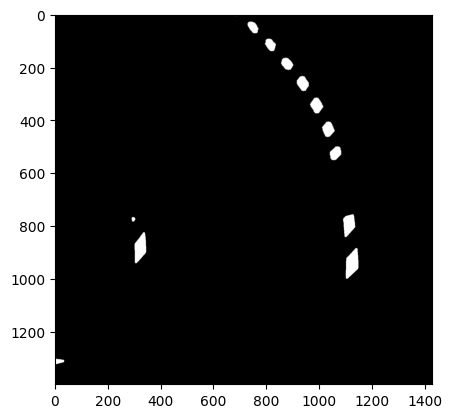

In [50]:
x = merge(img_ft_hsv, img_lt_hsv, img_rt_hsv)
type(x)
x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

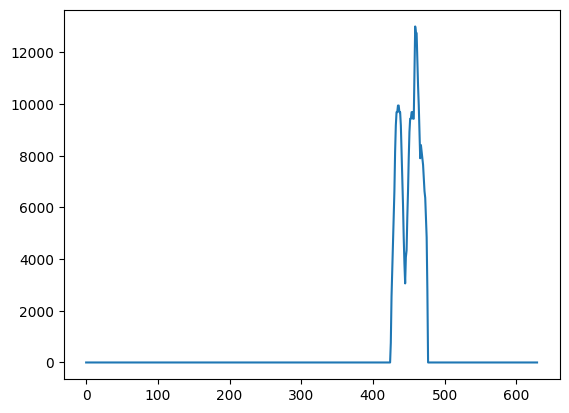

0 459


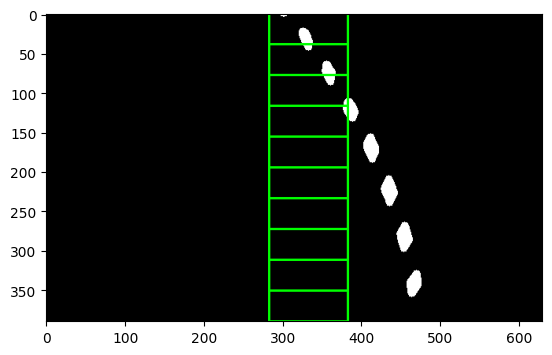

In [30]:
img_out = cv2.cvtColor(img_ft_hsv, cv2.COLOR_BGR2RGB)
img_out_bi = img_ft_hsv
# img_out = img_ft_hsv
# print(type(img_warped_croped))
# HYPERPARAMETERS
# Choose the number of sliding windows
check_left = False
check_right = False
nwindows = 10


# Set the width of the windows +/- margin
margin = 50

# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int64(img_out.shape[0]//nwindows)


# Take a histogram of the bottom half of the image
# histogram = np.sum(img_out[img_out.shape[0]-window_height:img_out.shape[0],:], axis=0)
histogram = np.sum(img_out_bi[200:], axis=0)
plt.plot(histogram)
plt.show()

# find lane
midpoint = np.int64(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
if leftx_base != 0:
    check_left = True
rightx_base = np.argmax(histogram[midpoint:])
if rightx_base != 0:
    rightx_base = rightx_base + midpoint
    check_right = True


print(leftx_base, rightx_base)

# find nonzero value in out_img
nonzero = img_out.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
# for window in range(nwindows):
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = img_out.shape[0] - (window+1)*window_height
    win_y_high = img_out.shape[0] - window*window_height
    # print(win_y_low, win_y_high)
    
    if check_left == True:
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        cv2.rectangle(img_out,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        
    ### TO-DO: Find the four below boundaries of the window ###
    if check_right == True:
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        cv2.rectangle(img_out,(win_xleft_low, win_y_low),(win_xleft_high, win_y_high),(0,255,0), 2) 
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        right_lane_inds.append(good_right_inds)
        
            
    # print(leftx_current, rightx_current)
    # print(win_xleft_low, win_xleft_high)
    # print(win_xright_low, win_xright_high)


    # Draw the windows on the visualization image
    # plt.imshow(xx)
    ### TO-DO: Identify the nonzero pixels in x and y within the window ###
    # Append these indices to the lists

    ### TO-DO: If you found > minpix pixels, recenter next window ###
    ### (`right` or `leftx_current`) on their peak histogram ###
    if(len(good_left_inds) > minpix):
        leftx_current = np.int64(np.mean(nonzerox[good_left_inds]))
    if(len(good_right_inds) > minpix):
        rightx_current = np.int64(np.mean(nonzerox[good_right_inds]))

# plt.figure(figsize = (24, 9))
# img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
plt.imshow(img_out)

In [24]:
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
img_out
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, img_out.shape[0]-1, img_out.shape[0] )
# print(ploty)
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

## Visualization ##
# Colors in the left and right lane regions
img_out[lefty, leftx] = [255, 0, 0]
img_out[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')

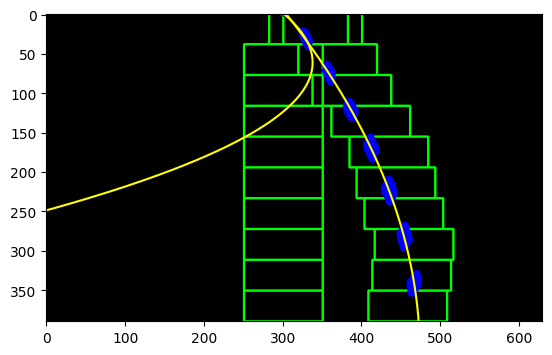

In [25]:
img_out[lefty, leftx] = [255, 0, 0]
img_out[righty, rightx] = [0, 0, 255]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(img_out)

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (2185,9)